# DDPM on graphs

A try on using continuous diffusion on graph edges. An edge_weight of 255 means that the edge exists and an edge_weight of 0 means that the edge doesn't exist. Edge weights are noised using gaussian noise and denoised using a GCN-based nn.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.ops import MLP
import torch_geometric
from torch_geometric.data import Data, Dataset, download_url
from torch_geometric.transforms import BaseTransform
from torch.nn import functional as F
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.utils import degree, to_torch_csr_tensor, scatter
import random
from copy import deepcopy
import os
import os.path as osp
from tqdm.notebook import tqdm

# Data generation

In [2]:
def wilson_algorithm(G, start):
    """
    Wilson's algorithm for generating a uniform spanning tree on a graph.

    Parameters:
    - G: NetworkX graph
    - start: starting node for the algorithm

    Returns:
    - T: Uniform spanning tree of G
    """
    U = {start}
    T = deepcopy(G)
    nx.set_edge_attributes(T, {e:{"edge_weight":0.} for e in T.edges(data=False)})
    nx.set_node_attributes(T, {n:{'pos':n} for n in T.nodes(data=False)})
    while len(U) < len(G.nodes):
        u = random.choice(list(set(G.nodes) - U))
        path = [u]
        while u not in U:
            u = random.choice(list(G.neighbors(u)))
            if u in path:
                cycle_index = path.index(u)
                path = path[:cycle_index + 1]
            else:
                path.append(u)
        U.update(path)
        nx.set_edge_attributes(T, {(path[i], path[i + 1]):{"edge_weight":1.} for i in range(len(path) - 1)})
    return T

def generate_ust_maze(width, height):
    """
    Generates a maze using Wilson's algorithm.

    Parameters:
    - width: width of the maze
    - height: height of the maze

    Returns:
    - T: Uniform spanning tree representing the maze
    """
    G = nx.grid_2d_graph(width, height)
    start = (random.randint(0, width-1), random.randint(0, height-1))
    T = wilson_algorithm(G, start)
    return T

def generate_ust_maze_list(size, width, height):
    """
    Generates a maze dataset

    Parameters:
    - width: width of the maze
    - height: height of the maze

    Returns:
    - L a list of maze
    """
    L = []
    for i in range(size):
        L.append(generate_ust_maze(width, height))
    
    return L

def write_ust_maze_list(L, dir_name):
    """
    Writes a list of mazes in a specified file

    Parameters:
    - L: list of ust mazes
    - dir_name: The name of the directory to write the list
    """

    for i, G in enumerate(L):
        nx.write_gml(G, dir_name+"/Graph_"+str(i), stringizer=nx.readwrite.gml.literal_stringizer)

def draw_maze(T, width, height):
    """
    Draw the maze represented by the uniform spanning tree T.

    Parameters:
    - T: Uniform spanning tree representing the maze
    - width: width of the maze
    - height: height of the maze
    """
    pos = {n:pos for (n,pos) in nx.get_node_attributes(T, "pos").items()}
    real_edges = [e for (e,v) in nx.get_edge_attributes(T, "edge_weight").items() if v==1]
    plt.figure(figsize=(10, 10))
    nx.draw(T.edge_subgraph(real_edges), pos=pos, with_labels=False, node_size=10, width=2, edge_color='blue')
    plt.xlim(-1, width)
    plt.ylim(-1, height)
    plt.gca().invert_yaxis()
    plt.show()

def draw_Data(G, width, height):
    """
    Draw ther maze represented by the graph G

    Parameters:
    - G: torch_geometric graph
    - width: width of the maze
    - height: height of the maze
    """

    T = to_networkx(G, to_undirected=True, node_attrs=['pos'], edge_attrs=['edge_weight'])
    draw_maze(T, width, height)

# Dataset

In [3]:
class Maze_dataset(Dataset):
    """
    A class to represent a Dataset of maze
    """
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, force_reload=False):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.pre_transform = pre_transform
        self.transform = transform
        self.pre_filter = pre_filter
        self.root = root

    @property
    def raw_file_names(self):
        return [f for f in os.listdir(self.root+"/raw")]

    @property
    def processed_file_names(self):
        return [f for f in os.listdir(self.root+"/processed")]

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            raw_graph = nx.read_gml(raw_path)

            data = from_networkx(raw_graph)

            data.edge_index, data.edge_weight = torch_geometric.utils.coalesce(edge_index=data.edge_index, edge_attr=data.edge_weight)

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data
    
    def get_raw(self, idx):
        G = nx.read_gml(osp.join(self.raw_dir, f'Graph_{idx}'), destringizer=nx.readwrite.gml.literal_destringizer)
        return G

In [8]:
L = generate_ust_maze_list(100, 32, 32)
write_ust_maze_list(L, "D3PM/dataset32/raw")

In [4]:
dataset = Maze_dataset("D3PM/dataset32")

In [5]:
len(dataset), dataset[0]

/tmp/ipykernel_3938647/163337004.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


(102, Data(edge_index=[2, 3968], pos=[1024, 2], edge_weight=[3968]))

# Model design

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [7]:
class DDPM(nn.Module):
    """
    A class to represent a diffusion model using the network parameter as a denoiser.
    From https://dataflowr.github.io/website/modules/18a-diffusion/.
    """
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device):
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 

    def add_noise(self, G_start, noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps] # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
        s1 = s1.reshape(-1) # (bs, 1, 1, 1)
        s2 = s2.reshape(-1) # (bs, 1, 1, 1)

        noised_G = G_start.clone()
        noised_G.edge_weight = torch.clip(s1 * noised_G.edge_weight + s2 * noise, min=0., max=255.)

        return noised_G

    def reverse(self, batch, t):
        # The network estimates the noise added
        return self.network(batch, t)

    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1)
        pred_prev_sample = sample.clone()
        pred_prev_sample.edge_weight = coef_first_t*(sample.edge_weight-coef_eps_t*model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample.edge_weight += variance
        
        return pred_prev_sample

In [8]:
def sinusoidal_embedding(n, d):
    """
    Returns the sinusoidal positional encoding of dimension d for n timesteps.
    """
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [48]:
class AddEdgeWeightPE(BaseTransform):
    """
    A transform class to add data about adjacent edges state in each nodes' embedding

    This implementation is not efficient at all it is just meant for little tests, which aren't conclusive.
    """
    def __init__(self, walk_length: int) -> None:
        self.walk_length = walk_length

    def forward(self, data: Data) -> Data:
        assert data.edge_index is not None
        assert data.edge_weight is not None

        row, col = data.edge_index
        N = data.num_nodes

        value = data.edge_weight / 255
        #Normalize

        adj = torch.zeros((N,N)).to(device)
        adj[row,col] = value

        degrees = torch.sum(1 * (adj > 0), axis=1)
        max_deg = torch.max(degrees).int()

        out = deepcopy(adj)

        adj = (1/degrees.unsqueeze(1)) * adj # So the embedding carries its exact edges data

        pe = torch.zeros((N, self.walk_length, max_deg)).to(device)
        for k in range(self.walk_length - 1):
            for i in range(N):
                pe[i,k,:degrees[i]] = out[i][adj[i].nonzero(as_tuple=True)] 

            out = out @ adj

        pe = pe.reshape(N, -1)
        if data.x is not None:
            data.x = torch.hstack((data.x, pe))

        else:
            data.x = pe

        return data

In [49]:
class Network(nn.Module):
    """
    A basic GNN model to denoise in the diffusion process.
    """
    def __init__(self, max_deg=4, walk_length=8, n_steps=1000, time_emb_dim=100, num_gcn_layers=3, num_mlp1_layers=2, num_mlp2_layers=2):
        super().__init__()
        self.emb_size = time_emb_dim+max_deg*walk_length

        self.mlp1 = MLP(in_channels=self.emb_size, hidden_channels=[self.emb_size for _ in range(num_mlp1_layers)])
        self.GNN = torch_geometric.nn.GCN(in_channels=self.emb_size, 
                                          hidden_channels=2*self.emb_size, 
                                          num_layers=num_gcn_layers, 
                                          out_channels=2*self.emb_size,
                                         )
        
        self.mlp2 = MLP(in_channels=4*self.emb_size, hidden_channels=[4*self.emb_size for _ in range(num_mlp2_layers)]+[1])
        
        self.transform = AddEdgeWeightPE(walk_length=walk_length)
        self.time_embedding = sinusoidal_embedding(n_steps, time_emb_dim).to(device)
    
    def forward(self, batch, t):
        batch = self.transform(batch)
        t = self.time_embedding[t]
        batch.x = torch.cat((batch.x, t), 1)


        y = self.mlp1(batch.x)
        y = self.GNN(x=y, edge_index=batch.edge_index, edge_weight=batch.edge_weight)
        y = torch.cat((y[batch.edge_index[0]].T, y[batch.edge_index[1]].T)).T
        out = self.mlp2(y)
        
        return out.reshape(-1,)

In [52]:
num_timesteps = 1000
walk_length = 32
time_emb_dim = 100
batch_size = 1
data_size = 1
num_gcn_layers = 3
num_mlp1_layers = 2
num_mlp2_layers = 2

network = Network(max_deg=4, walk_length=walk_length, n_steps=num_timesteps, time_emb_dim=time_emb_dim, num_gcn_layers=num_gcn_layers, num_mlp1_layers=num_mlp1_layers, num_mlp2_layers=num_mlp2_layers)
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

model = DDPM(network, num_timesteps)
#model.load_state_dict(torch.load('model_weights.pth', weights_only=True))

train_loader = torch_geometric.loader.DataLoader(dataset[:data_size], batch_size=batch_size, shuffle=True)

/tmp/ipykernel_3938647/163337004.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))


tensor([930], device='cuda:0')
Currently at epoch n°:0, running loss is: 32688.8203125
Currently at epoch n°:1, running loss is: 32629.13671875
Currently at epoch n°:2, running loss is: 32429.3046875
Currently at epoch n°:3, running loss is: 31840.58203125
Currently at epoch n°:4, running loss is: 30406.3203125
Currently at epoch n°:5, running loss is: 27348.703125
Currently at epoch n°:6, running loss is: 21853.8828125
Currently at epoch n°:7, running loss is: 15219.0625
Currently at epoch n°:8, running loss is: 22940.55078125
Currently at epoch n°:9, running loss is: 17273.099609375
Currently at epoch n°:10, running loss is: 14407.9072265625
Currently at epoch n°:11, running loss is: 15698.861328125
Currently at epoch n°:12, running loss is: 17386.5625
Currently at epoch n°:13, running loss is: 18239.560546875
Currently at epoch n°:14, running loss is: 18164.89453125
Currently at epoch n°:15, running loss is: 17304.677734375
Currently at epoch n°:16, running loss is: 15938.88671875
C

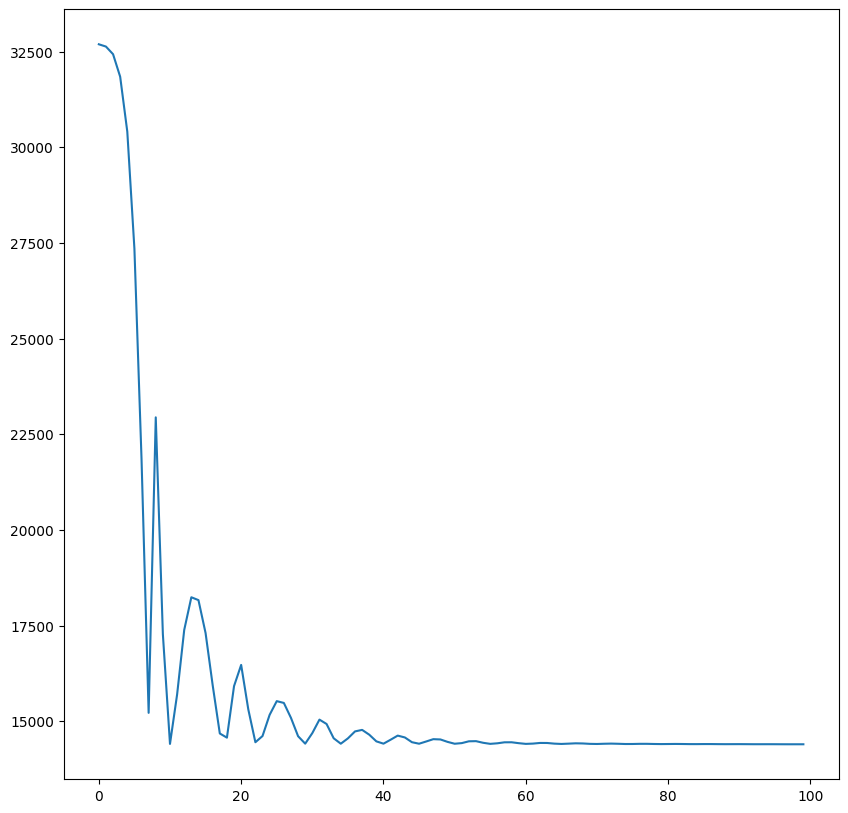

99 14398.19921875


In [53]:
num_epochs = 100
learning_rate = 0.001

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

losses = []

model.to(device)
for epoch in range(num_epochs):
        model.train()
        running_loss = 0.
        # inside the training loop
        for step, batch in enumerate(train_loader):
                #if step % (len(train_loader)//10)==0:
                #    print("step: "+str(step)+", running_loss: "+str(running_loss))
                batch = batch.to(device)
                batch.edge_weight *= 255
                if epoch==0:
                        noise = torch.randn(batch.edge_weight.shape).to(device)
                        undirected_noise_indices = (batch.edge_index[0] < batch.edge_index[1]) * batch.csr()[2] + (batch.edge_index[0] >= batch.edge_index[1]) * batch.csc()[2]
                        noise = noise[undirected_noise_indices] #To have undirected noise

                        timesteps = torch.randint(0, num_timesteps, (batch_size,)).to(device)
                        print(timesteps)

                t_nodes = timesteps[batch.batch]
                t_edges = timesteps[batch.batch[batch.edge_index[0]]]
            
                noisy = model.add_noise(batch, noise, t_edges)
                clipped_noise = noisy.edge_weight - batch.edge_weight
                noise_pred = model.reverse(batch=noisy, t=t_nodes)

                loss = F.mse_loss(noise_pred, clipped_noise)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                running_loss += loss.item() / len(train_loader)
                
        losses.append(running_loss)
    
        print("Currently at epoch n°:"+str(epoch)+", running loss is: "+str(running_loss))
    
        torch.save(model.state_dict(), 'model_weights.pth')
    
plt.figure(figsize=(10,10))
plt.plot(range(len(losses)), losses)
plt.show()
print(epoch, losses[-1])

# Current results

Even with a fixed noise on a single sample the model isn't able to learn.